In [2]:
# pipeline.py
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
import warnings
warnings.filterwarnings('ignore')


In [4]:


# === 1. Connect to PostgreSQL and fetch data ===
conn = psycopg2.connect(
    host="localhost",
    database="synthetic",   # CHANGE THIS
    user="postgres",
    password="postgres",  # CHANGE THIS
    port=5432
)

query = "SELECT * FROM customers;"
df = pd.read_sql(query, conn)
conn.close()

print(f"Data fetched from PostgreSQL: {df.shape}")
print(df.head())


Data fetched from PostgreSQL: (5000, 8)
   customer_id   age  annual_income  spending_score  days_since_last_purchase  \
0            1   NaN            NaN            18.8                       0.1   
1            2  33.0       25267.36            17.0                      55.1   
2            3  42.0            NaN            51.1                     148.6   
3            4   NaN       27887.33            31.9                      42.6   
4            5   NaN            NaN            38.4                       0.2   

   credit_score   region signup_date  
0         585.0  Central  2023-08-02  
1         621.0    South  2020-08-16  
2         538.0    South  2020-02-21  
3         641.0    South  2024-02-27  
4         625.0    North  2021-07-17  


In [6]:

# === 2. Save to CSV (for backup) ===
df.to_csv('fetched_customers_from_pg.csv', index=False)

# === 3. Exploratory Data Analysis (EDA) ===
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

print(f"Missing values:\n{df.isnull().sum()}")



EXPLORATORY DATA ANALYSIS
Missing values:
customer_id                    0
age                         2223
annual_income               3500
spending_score               400
days_since_last_purchase       0
credit_score                 400
region                       250
signup_date                    0
dtype: int64


In [7]:

numerical_cols = ['age', 'annual_income', 'spending_score', 
                  'days_since_last_purchase', 'credit_score']
categorical_cols = ['region']


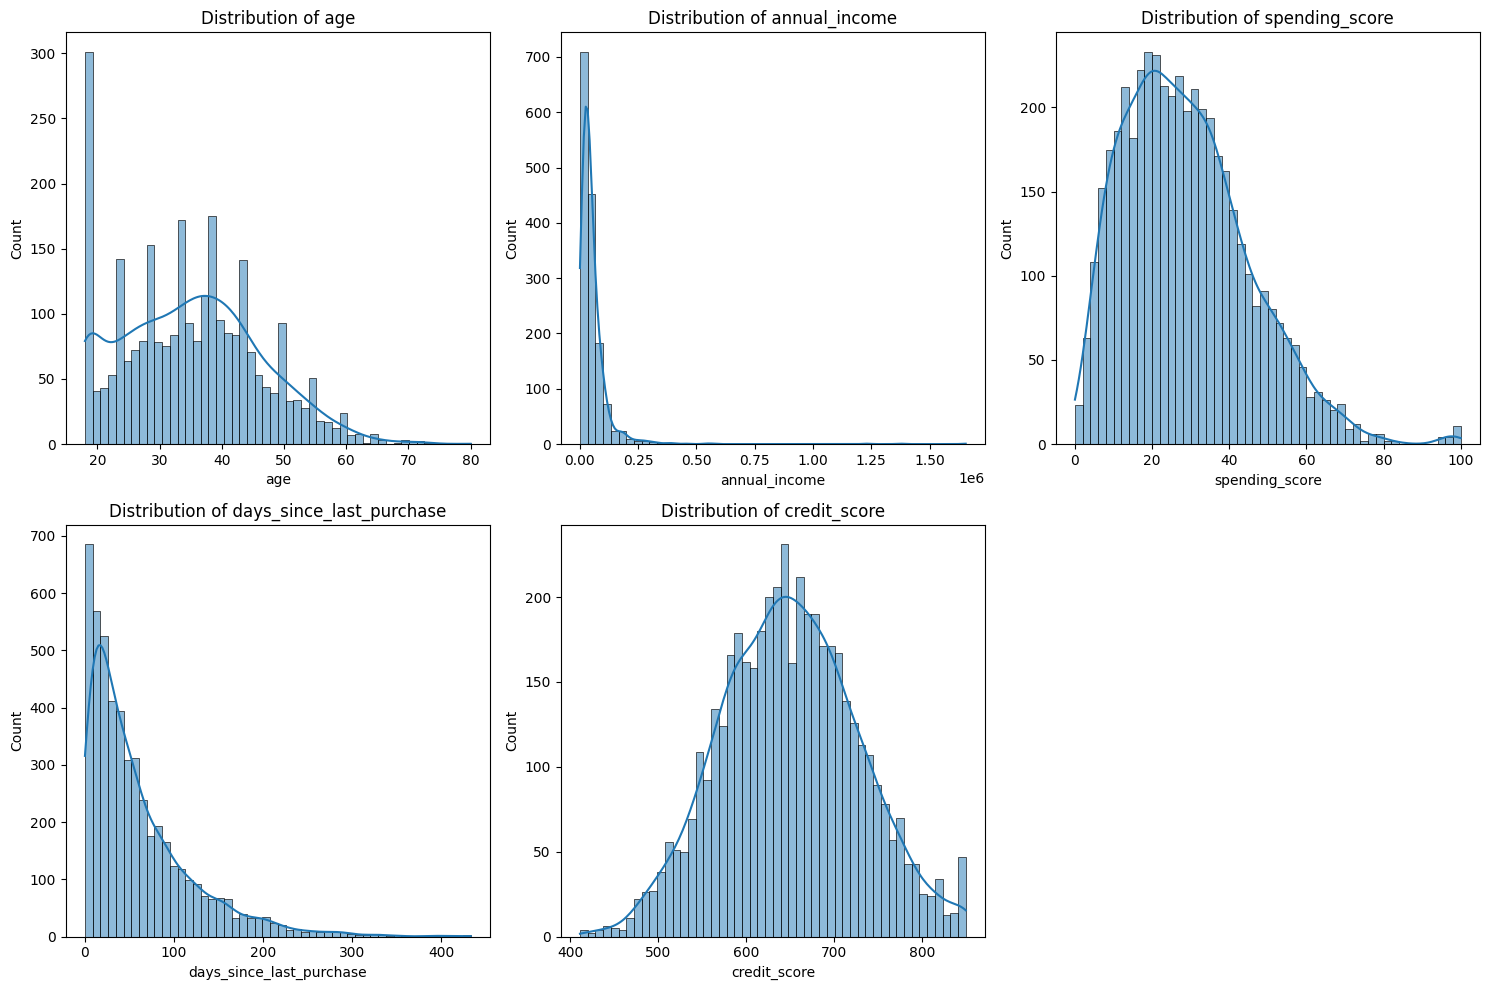

In [8]:

# Distribution plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, kde=True, bins=50)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


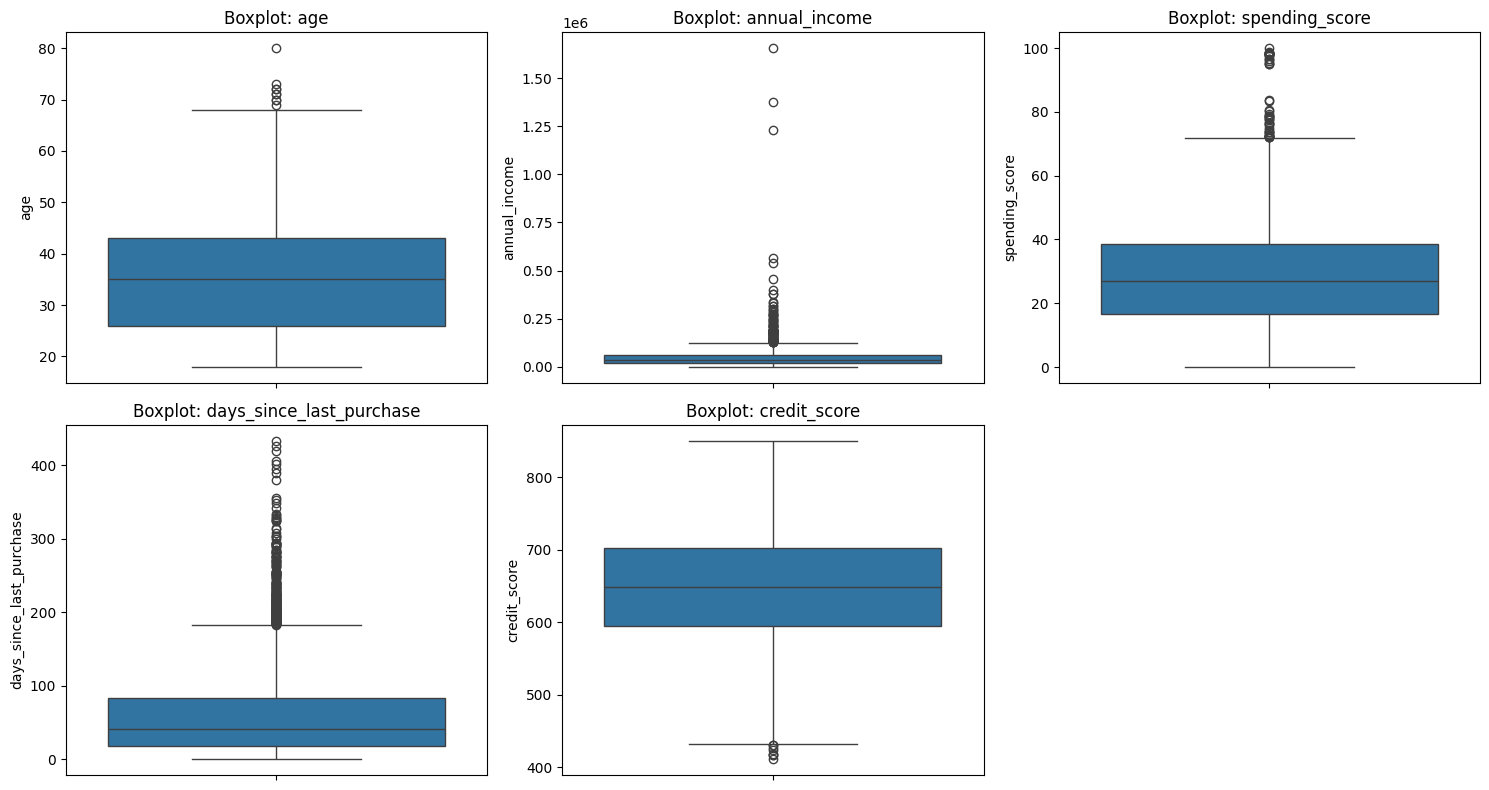

In [9]:

# Box plots to see outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()


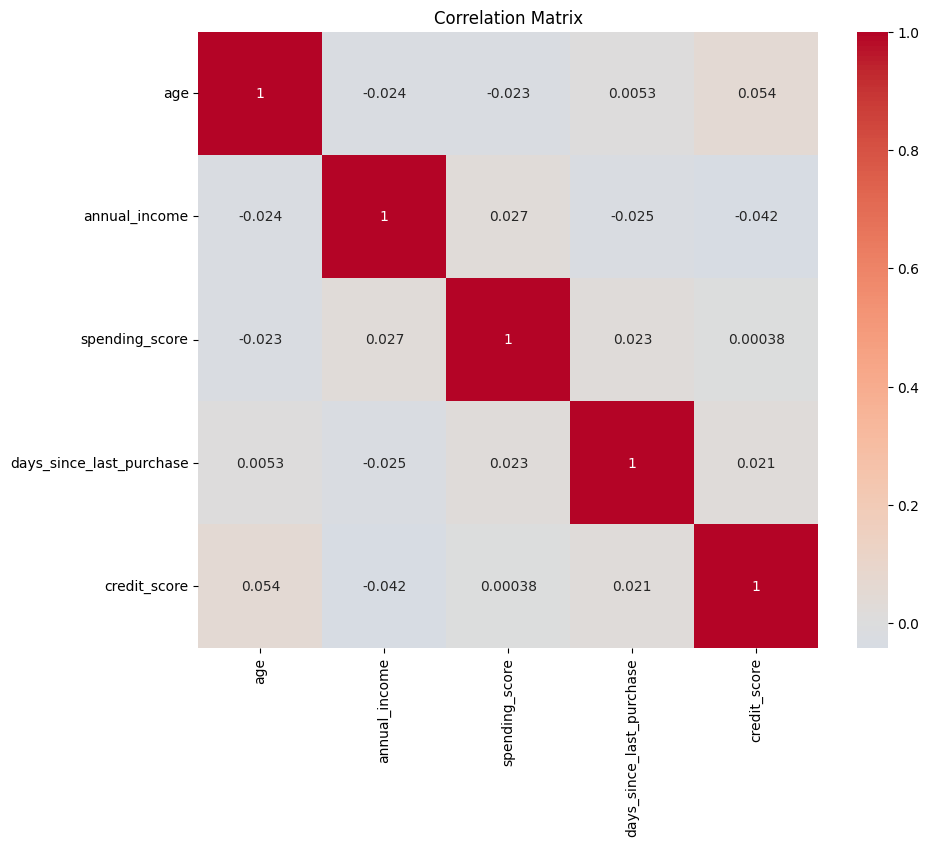

In [10]:

# Correlation heatmap (only numeric)
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


In [11]:

# === 4. Imputation Strategies ===

df_imputed = df.copy()

# Strategy 1: Simple imputation (median/mode)
simple_imputer_num = SimpleImputer(strategy='median')
simple_imputer_cat = SimpleImputer(strategy='most_frequent')

df_imputed[numerical_cols] = simple_imputer_num.fit_transform(df[numerical_cols])
df_imputed[categorical_cols] = simple_imputer_cat.fit_transform(df[categorical_cols])

# Strategy 2: KNN Imputation (better for complex missingness)
df_knn = df.copy()
knn_imputer = KNNImputer(n_neighbors=5)
df_knn[numerical_cols] = knn_imputer.fit_transform(df[numerical_cols])
df_knn[categorical_cols] = simple_imputer_cat.fit_transform(df[categorical_cols])

# One-hot encode region for final use
df_imputed = pd.get_dummies(df_imputed, columns=['region'], prefix='region')
df_knn = pd.get_dummies(df_knn, columns=['region'], prefix='region')

# Save cleaned versions
df_imputed.to_csv('cleaned_simple_imputation.csv', index=False)
df_knn.to_csv('cleaned_knn_imputation.csv', index=False)

print("\nImputation completed!")
print("Files saved:")
print("  - fetched_customers_from_pg.csv")
print("  - cleaned_simple_imputation.csv")
print("  - cleaned_knn_imputation.csv")



Imputation completed!
Files saved:
  - fetched_customers_from_pg.csv
  - cleaned_simple_imputation.csv
  - cleaned_knn_imputation.csv


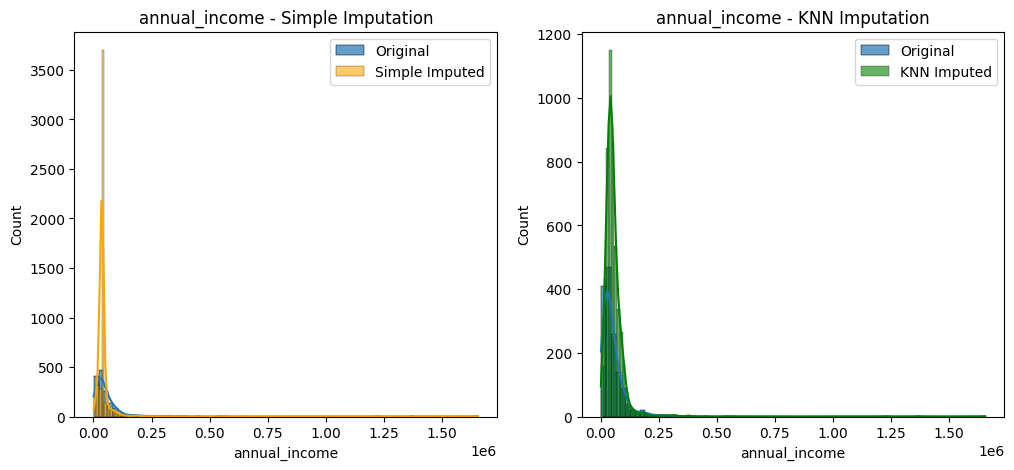

In [12]:

# Optional: Compare distributions before/after imputation
col = 'annual_income'
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df[col].dropna(), kde=True, label='Original', alpha=0.7)
sns.histplot(df_imputed[col], kde=True, color='orange', label='Simple Imputed', alpha=0.6)
plt.legend()
plt.title(f"{col} - Simple Imputation")

plt.subplot(1, 2, 2)
sns.histplot(df[col].dropna(), kde=True, label='Original', alpha=0.7)
sns.histplot(df_knn[col], kde=True, color='green', label='KNN Imputed', alpha=0.6)
plt.legend()
plt.title(f"{col} - KNN Imputation")
plt.show()